August: Defining transport sections on the plane that cuts vertically at the shelf break. This is specifically for V transport.

In [1]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

## Key variables:
* gdepv: depth of V-grid points
* vmask: mask for V-grid
* mbathy: fortran (1-based) index of deepest water cell, T-grid
* e1v
* e3v

In [8]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

with nc.Dataset(os.path.join(path, '1_mesh_mask.nc'), 'r') as nbl:
    gdepv = nbl.variables['gdepv'][0, :, 1, 1]
    vmask = nbl.variables['umask'][0,...]
    mbathy = nbl.variables['mbathy'][0,...]
    e1v = nbl.variables['e1v'][0,...]
    e3v_0 = nbl.variables['e3v_0'][0,...]    

In [18]:
# z index of the shelf platform
# 1. find where the depth of v point is closest to 80
# 2. re-assess answer later
ind_shelf = np.argmin(np.abs(gdepv - 80))

print(ind_shelf)

# y index of shelf break 
# 1. get top view of vmask at shelf depth
# 2. extract wet/dry values along x=1 
# 3. find the first wet cell
ind_plane = np.where(vmask[ind_shelf, :, 1] == 1)[0][0]

print(ind_plane)

# z index of the shelf platform
cells_shelf = vmask[ind_shelf, ind_plane, :]
cells_shelf_W = np.count_nonzero(cells_shelf)
cells_shelf_D = vmask.shape[-1] - cells_shelf_W
while cells_shelf_D < 4:
    ind_shelf += 1
    cells_shelf = vmask[ind_shelf, ind_plane, :]
    cells_shelf_W = np.count_nonzero(cells_shelf)
    cells_shelf_D = vmask.shape[-1] - cells_shelf_W
depth_shelf = gdepv[ind_shelf]

print(ind_shelf, depth_shelf)

# z index of canyon bottom
# 1. mbathy gives maximum depth level everywhere
# 2. this value is given in fortran indexing
# 3. subtracting 1 gives the deepest level with wet cells
ind_bottom = (mbathy[ind_plane,:].max())-1
depth_bottom = gdepv[ind_bottom]

print(ind_bottom, depth_bottom)

# x index of canyon axis
# 1. find all wet cells along canyon bottom
# 2. find the middle wet cell for symmetric axis
# 3. this could have a 0.5 so return integer

ind_axis = int(np.median(np.where(vmask[ind_bottom, ind_plane, :]==1)))
print(ind_axis)

# x index of rims
# 1. last land value on left
# 2. first land value on right
ind_rimL = np.where(vmask[ind_shelf, ind_plane, :ind_axis]==0)[0][-1]
ind_rimR = np.where(vmask[ind_shelf, ind_plane, ind_axis:]==0)[0][0] + ind_axis - 1

print(ind_rimL, ind_rimR)

# area of wet cells
vmask_plane = vmask[:,ind_plane,:]
cell_x_j = e1v[ind_plane, :]
cell_y_j = e3v_0[:,ind_plane,:]
area_j = vmask_plane * cell_x_j * cell_y_j

print(area_j.shape)

# calculate the area of all cells along a single row
area_all = np.zeros(area_j.shape[0])
for depth_ind in range(area_j.shape[0]):
    area_row =area_j[depth_ind,:].sum()
    area_all[depth_ind] = area_row

print(area_all.shape)

# narrow down the areas of rows to only those inside canyon
area_canyon = area_all[ind_shelf:ind_bottom]
area_canyon_inds = np.arange(ind_shelf,ind_bottom)

# find row (or depth) at which we have half the area in canyon
total_area_canyon = np.sum(area_canyon)
half_area_canyon = total_area_canyon / 2
cumsum_area_canyon = np.cumsum(area_canyon)
half_area_canyon_ind = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()

ind_half = area_canyon_inds[half_area_canyon_ind]
depth_half = gdepv[ind_half]

print(ind_half, depth_half)

9
179
10 91.875
60 534.672
110
49 171
(80, 244)
(80,)
25 223.125


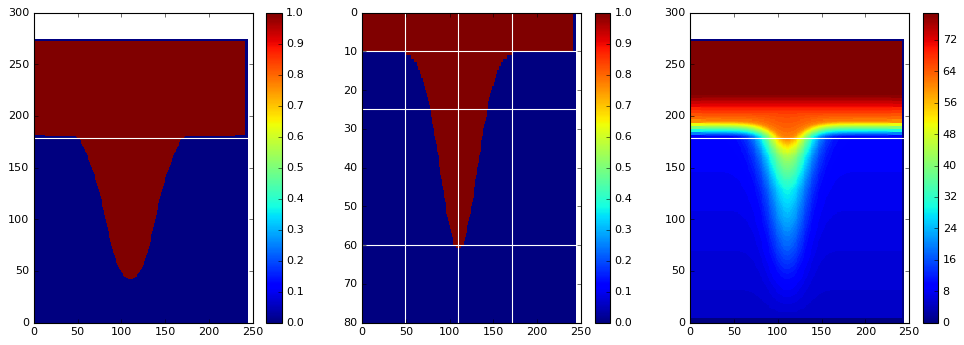

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
p1 = ax1.pcolor(vmask[ind_shelf, :, :])
p2 = ax2.pcolor(vmask[:, ind_plane, :])
p3 = ax3.pcolor(mbathy)
fig.colorbar(p1, ax=ax1)
fig.colorbar(p2, ax=ax2)
fig.colorbar(p3, ax=ax3)
ax2.invert_yaxis()

ax1.axhline(ind_plane, c='white')
ax2.axhline(ind_shelf, c='white')
ax2.axhline(ind_bottom, c='white')
ax2.axvline(ind_axis, c='white')
ax3.axhline(ind_plane, c='white')
ax2.axvline(ind_rimL, c='white')
ax2.axvline(ind_rimR, c='white')
ax2.axhline(ind_half, c='white')